<a href="https://colab.research.google.com/github/jlau0228/stock_predition/blob/main/code.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Jessica Lau MTH 4330 FINAL
## Recreation of The Random Forest Model for Analyzing and Forecasting the US Stock Market in the Context of Smart Finance
#Run each cell in order, graphs will show up. Cell 20 will have a lot of warnings and will take the longest ~ 8 minutes

In [ ]:
import yfinance as yf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from xgboost import XGBRFClassifier
from sklearn.metrics import accuracy_score, roc_auc_score, roc_curve, auc
from sklearn.datasets import make_moons
from sklearn.model_selection import TimeSeriesSplit, cross_val_score
import seaborn as sns
from sklearn import tree
from sklearn.tree import plot_tree, export_text
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix, classification_report, roc_auc_score, f1_score

In [ ]:
#smoothing function
def transform(Y: np.array, alpha: float)-> np.array:
    X=[Y[0]]
    for i in range(1, len(Y)):
        X.append(alpha * Y[i] + (1 - alpha) * X[i-1])
    return X

In [ ]:
#RSI function
def RSI(price):
  prices = price.to_numpy()
  gains=[]
  losses=[]
  for i in range(1, len(prices)):
    change = prices[i] - prices[i-1]
    if change >= 0:
      gains.append(change)
      losses.append(0)
    elif change < 0:
      gains.append(0)
      losses.append(abs(change))
  gains = np.array(gains)
  losses = np.array(losses)
  avg_gain = np.mean(gains[:14])
  avg_loss = np.mean(losses[:14])
  rsi = np.zeros(len(prices))
  for i in range(14, len(gains)):
    avg_gain = (avg_gain * 13 + gains[i]) / 14
    avg_loss = (avg_loss * 13 + losses[i]) / 14
    if avg_loss == 0:
      rsi[i] = 100
    else:
      rs = avg_gain / avg_loss
      rsi[i] = 100 - (100 / (1 + rs))
  return rsi

In [ ]:
# stochastic oscillator function
def stochastic_oscillator(price):
  prices = price.to_numpy()
  k = np.zeros(len(prices))
  for i in range(14, len(prices)):
    low = np.min(prices[i-14:i+1])
    high = np.max(prices[i-14:i+1])
    if low == high:
      k[i] = 0
    else:
      k[i] = 100 * ((prices[i] - low) / (high - low))
  return k

In [ ]:
# williams %r function
def williams_R(price):
  prices = price.to_numpy()
  r = np.zeros(len(prices))
  for i in range(14, len(prices)):
    low = np.min(prices[i-14:i+1])
    high = np.max(prices[i-14:i+1])
    if low == high:
      r[i] = 0
    else:
      r[i] = ((high - prices[i]) / (high - low))*(-100)
  return r

In [ ]:
# EMA function
def EMA(price, period):
  ema = np.zeros(len(price))
  ema[0] = price[0]
  factor = 2 / (period + 1)
  for i in range(1, len(price)):
    ema[i] = factor * price[i] + (1 - factor) * ema[i-1]
  return ema

In [ ]:
#MACD function
def MACD(price):
  prices = price.to_numpy()
  ema12 = EMA(prices, 12)
  ema26 = EMA(prices, 26)
  macd = ema12 - ema26
  signal = EMA(macd, 9)
  return macd - signal

In [ ]:
# price ROC function
def PROC(price):
  prices = price.to_numpy()
  proc = np.zeros(len(prices))
  for i in range(9, len(prices)):
    proc[i] = ((prices[i] - prices[i-9]) / prices[i-9])*100
  return proc

In [ ]:
# on balance volume function
def OBV(price, volume):
  prices = price.to_numpy()
  volumes = volume.to_numpy()
  obv = np.zeros(len(prices))
  for i in range(1, len(prices)):
    if prices[i] > prices[i-1]:
      obv[i] = obv[i-1] + volumes[i]
    elif prices[i] < prices[i-1]:
      obv[i] = obv[i-1] - volumes[i]
    else:
      obv[i] = obv[i-1]
  return obv

In [ ]:
# function that assigns if stock rises or falls based on given window
def windowprior(price, window):
  prices = price.to_numpy()
  outcome = np.zeros(len(prices))
  for i in range(len(prices)-window):
    if prices[i] > prices[i+window]:
      outcome[i] = 1
    else:
      outcome[i] = 0
  return outcome

In [ ]:
#Creating a dataframe for Apple data with the columns being the features of the stock
# get apple data
apple = yf.Ticker('AAPL')
applestock = apple.history(period="max")['Close']
appleclose = apple.history(period="max")['Close'].to_numpy()

appleclosesmooth = transform(appleclose, 0.1)
Apple = pd.Series.to_frame(applestock)
Apple['Date'] = list(applestock.index)
Apple['Volume'] = apple.history(period="max")['Volume']
Apple = Apple[['Date','Close','Volume']]
Apple.reset_index(drop=True, inplace=True)

#smooth closing with alpha = 0.1

appleclosesmooth = transform(Apple.loc[:,'Close'], 0.1)
Apple['Close1'] = appleclosesmooth

# apple rsi
applersi = RSI(Apple.loc[:,'Close1'])
Apple['RSI'] = applersi

#apple stochastic oscillator
applestk = stochastic_oscillator(Apple.loc[:,'Close1'])
Apple['Stochastic'] = applestk

#apple williams
applewill = williams_R(Apple.loc[:,'Close1'])
Apple['Williams'] = applewill

applemacd = MACD(Apple.loc[:,'Close1'])
Apple['MACD'] = applemacd

appleproc = PROC(Apple.loc[:,'Close1'])
Apple['PROC'] = appleproc

appleobv = OBV(Apple.loc[:,'Close1'], Apple.loc[:,'Volume'])
Apple['OBV'] = appleobv

apple30 = windowprior(Apple.loc[:,'Close1'], 30)
Apple['30'] = apple30

apple60 = windowprior(Apple.loc[:,'Close1'],60)
Apple['60'] = apple60

apple90 = windowprior(Apple.loc[:,'Close1'],90)
Apple['90'] = apple90


<ipython-input-14-720319704b4b>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Apple['Close1'] = appleclosesmooth
<ipython-input-14-720319704b4b>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Apple['RSI'] = applersi


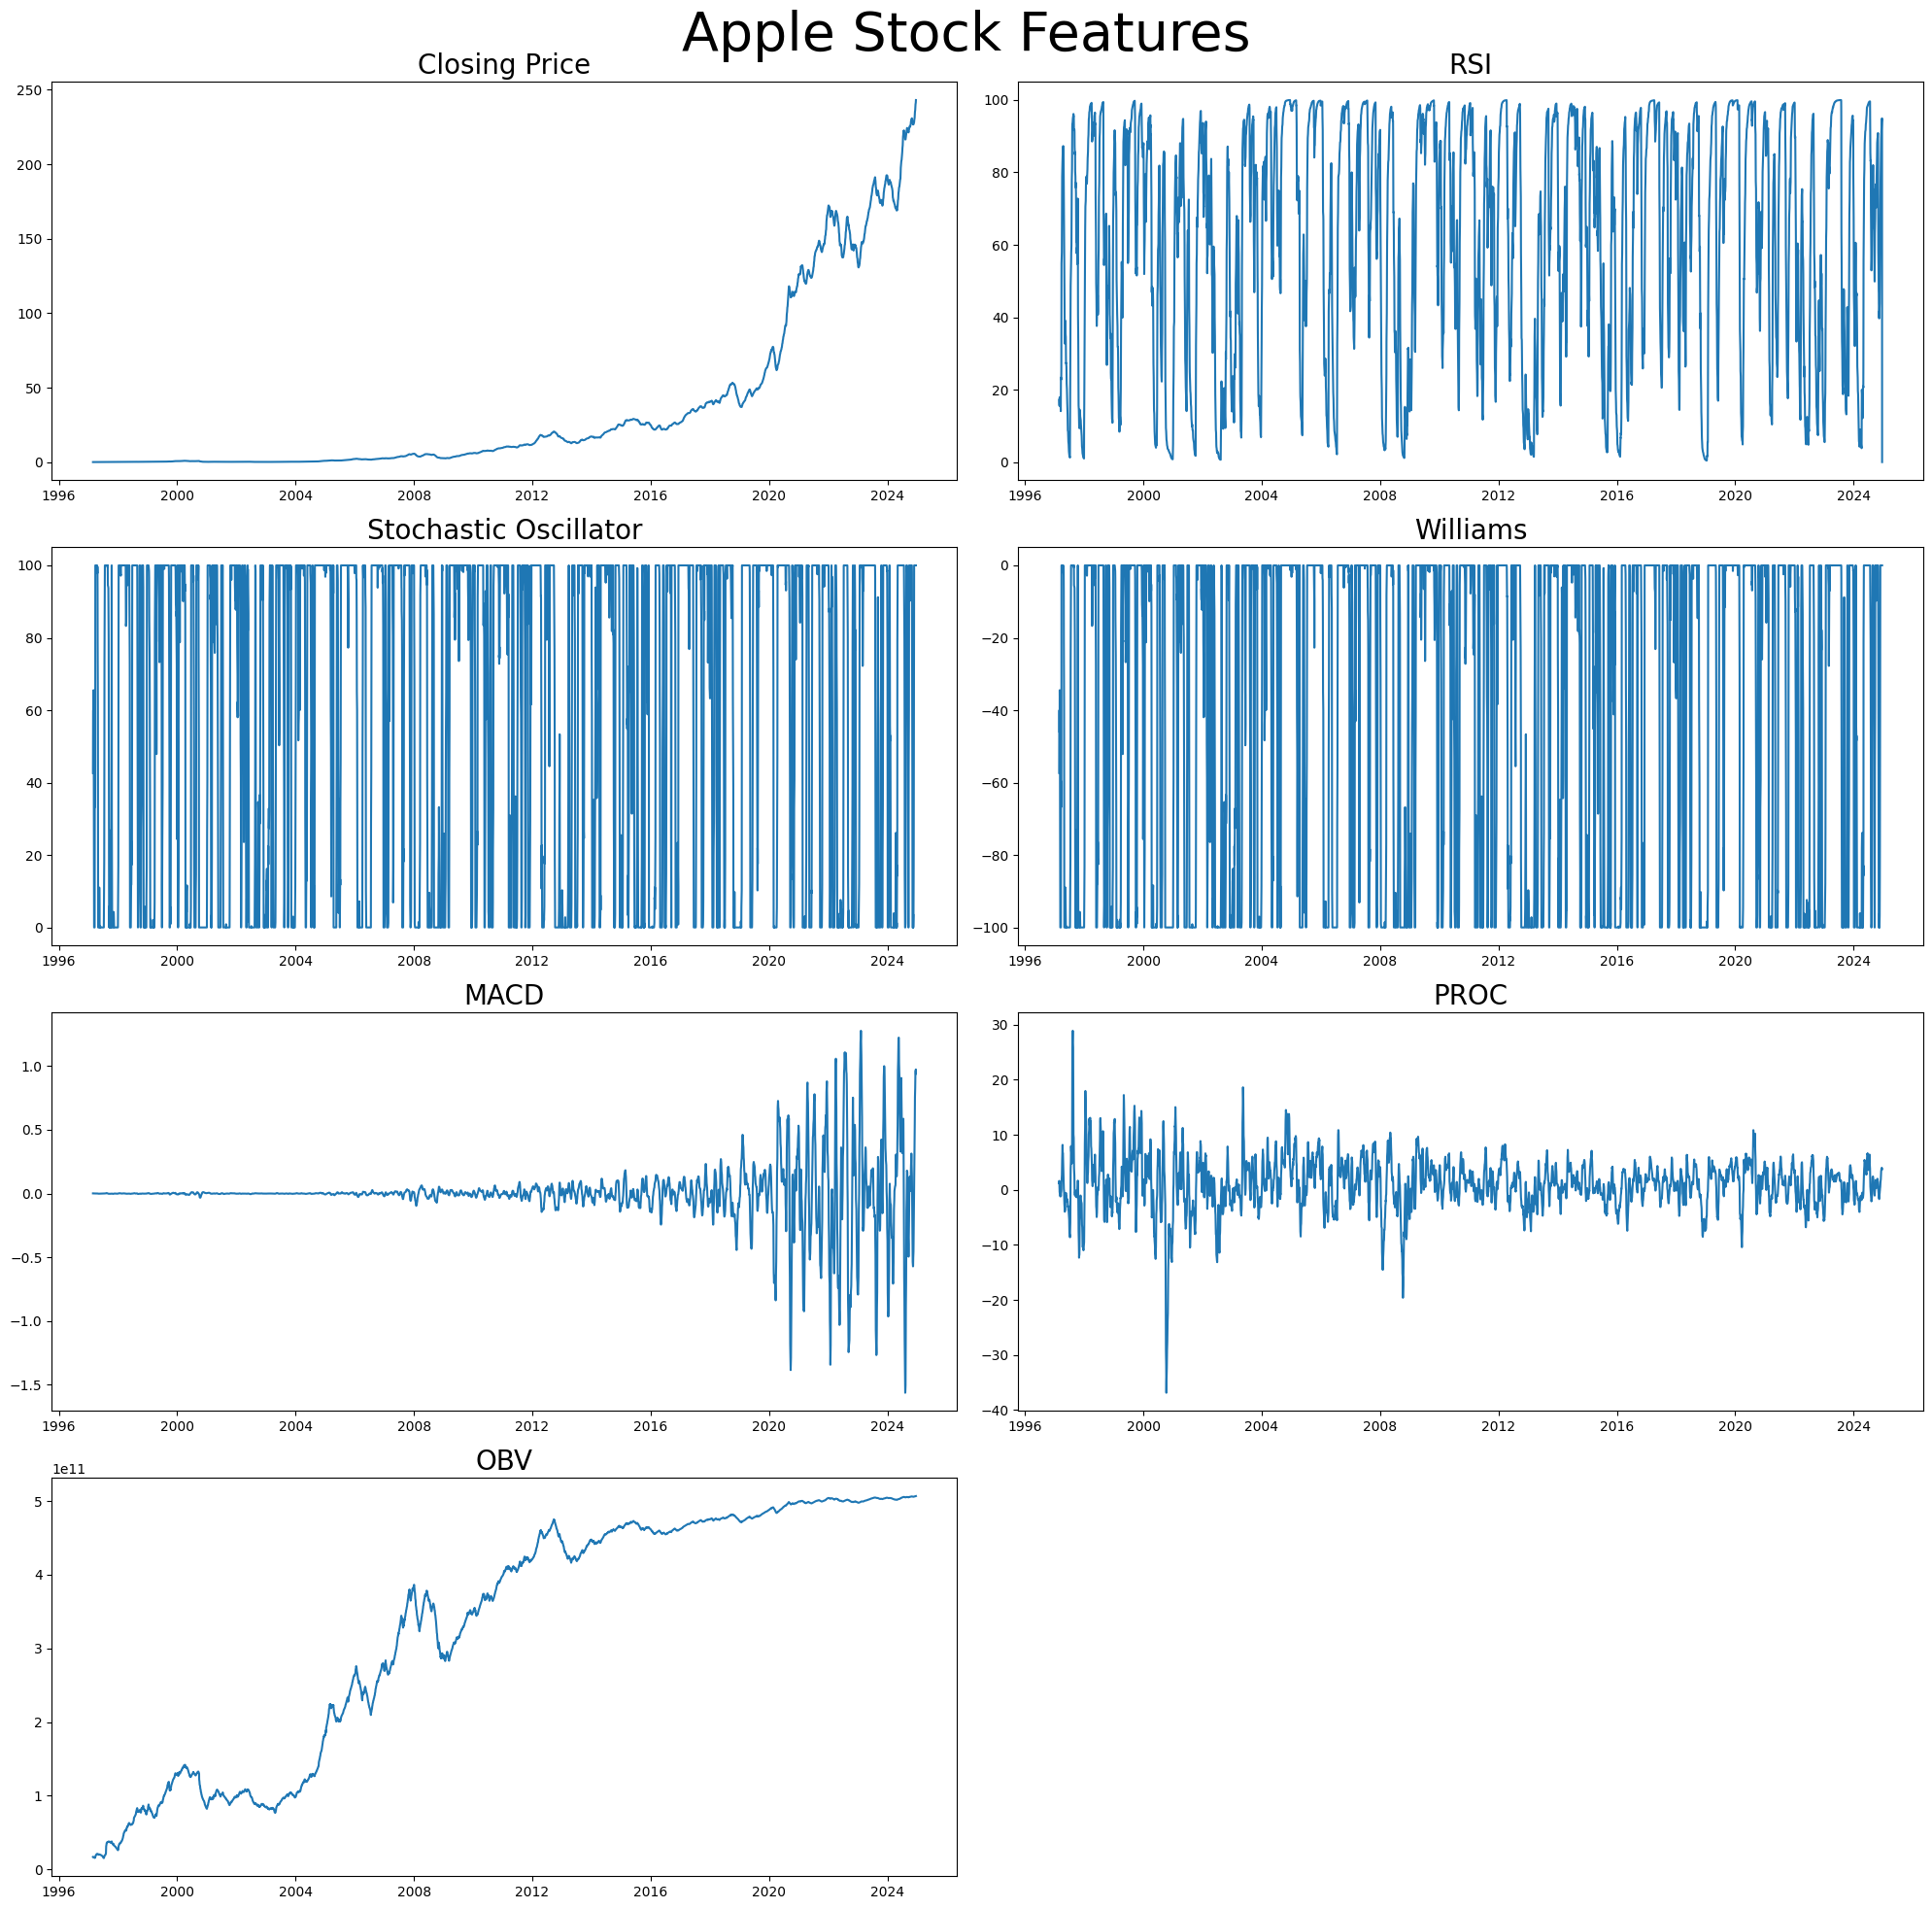

In [ ]:
#Plotting the Apple data features
fig, axs = plt.subplots(4,2, figsize=(20,20))
fig.suptitle('Apple Stock Features',fontsize = 40)
axs[0,0].plot(Apple['Date'].tail(7000), Apple['Close1'].tail(7000))
axs[0,0].set_title('Closing Price',fontsize=20)
axs[0,1].plot(Apple['Date'].tail(7000),Apple['RSI'].tail(7000))
axs[0,1].set_title('RSI',fontsize=20)
axs[1,0].plot(Apple['Date'].tail(7000),Apple['Stochastic'].tail(7000))
axs[1,0].set_title('Stochastic Oscillator',fontsize=20)
axs[1,1].plot(Apple['Date'].tail(7000),Apple['Williams'].tail(7000))
axs[1,1].set_title('Williams',fontsize=20)
axs[2,0].plot(Apple['Date'].tail(7000),Apple['MACD'].tail(7000))
axs[2,0].set_title('MACD',fontsize=20)
axs[2,1].plot(Apple['Date'].tail(7000),Apple['PROC'].tail(7000))
axs[2,1].set_title('PROC',fontsize=20)
axs[3,0].plot(Apple['Date'].tail(7000),Apple['OBV'].tail(7000))
axs[3,0].set_title('OBV',fontsize=20)
axs[3,1].set_visible(False)
fig.tight_layout()
plt.show()

In [ ]:
#Creating a dataframe for samsung data with the columns being the features of the stock
# get samsung data
samsung = yf.Ticker('005930.KS')
samsungstock = samsung.history(period="max")['Close']
samsungclose = samsung.history(period="max")['Close'].to_numpy()

samsungclosesmooth = transform(samsungclose, 0.1)
Samsung = pd.Series.to_frame(samsungstock)
Samsung['Date'] = list(samsungstock.index)
Samsung['Volume'] = samsung.history(period="max")['Volume']
Samsung = Samsung[['Date','Close','Volume']]
Samsung.reset_index(drop=True, inplace=True)

#smooth closing with alpha = 0.1

samsungclosesmooth = transform(Samsung.loc[:,'Close'], 0.1)
Samsung['Close1'] = samsungclosesmooth

# samsung rsi
samsungrsi = RSI(Samsung.loc[:,'Close1'])
Samsung['RSI'] = samsungrsi

#samsung stochastic oscillator
samsungstk = stochastic_oscillator(Samsung.loc[:,'Close1'])
Samsung['Stochastic'] = samsungstk

#samsung williams
samsungwill = williams_R(Samsung.loc[:,'Close1'])
Samsung['Williams'] = samsungwill

samsungmacd = MACD(Samsung.loc[:,'Close1'])
Samsung['MACD'] = samsungmacd

samsungproc = PROC(Samsung.loc[:,'Close1'])
Samsung['PROC'] = samsungproc

samsungobv = OBV(Samsung.loc[:,'Close1'], Samsung.loc[:,'Volume'])
Samsung['OBV'] = samsungobv

samsung30 = windowprior(Samsung.loc[:,'Close1'], 30)
Samsung['30'] = samsung30

samsung60 = windowprior(Samsung.loc[:,'Close1'],60)
Samsung['60'] = samsung60

samsung90 = windowprior(Samsung.loc[:,'Close1'],90)
Samsung['90'] = samsung90


<ipython-input-16-2972559e4df4>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Samsung['Close1'] = samsungclosesmooth
<ipython-input-16-2972559e4df4>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Samsung['RSI'] = samsungrsi
<ipython-input-16-2972559e4df4>:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/in

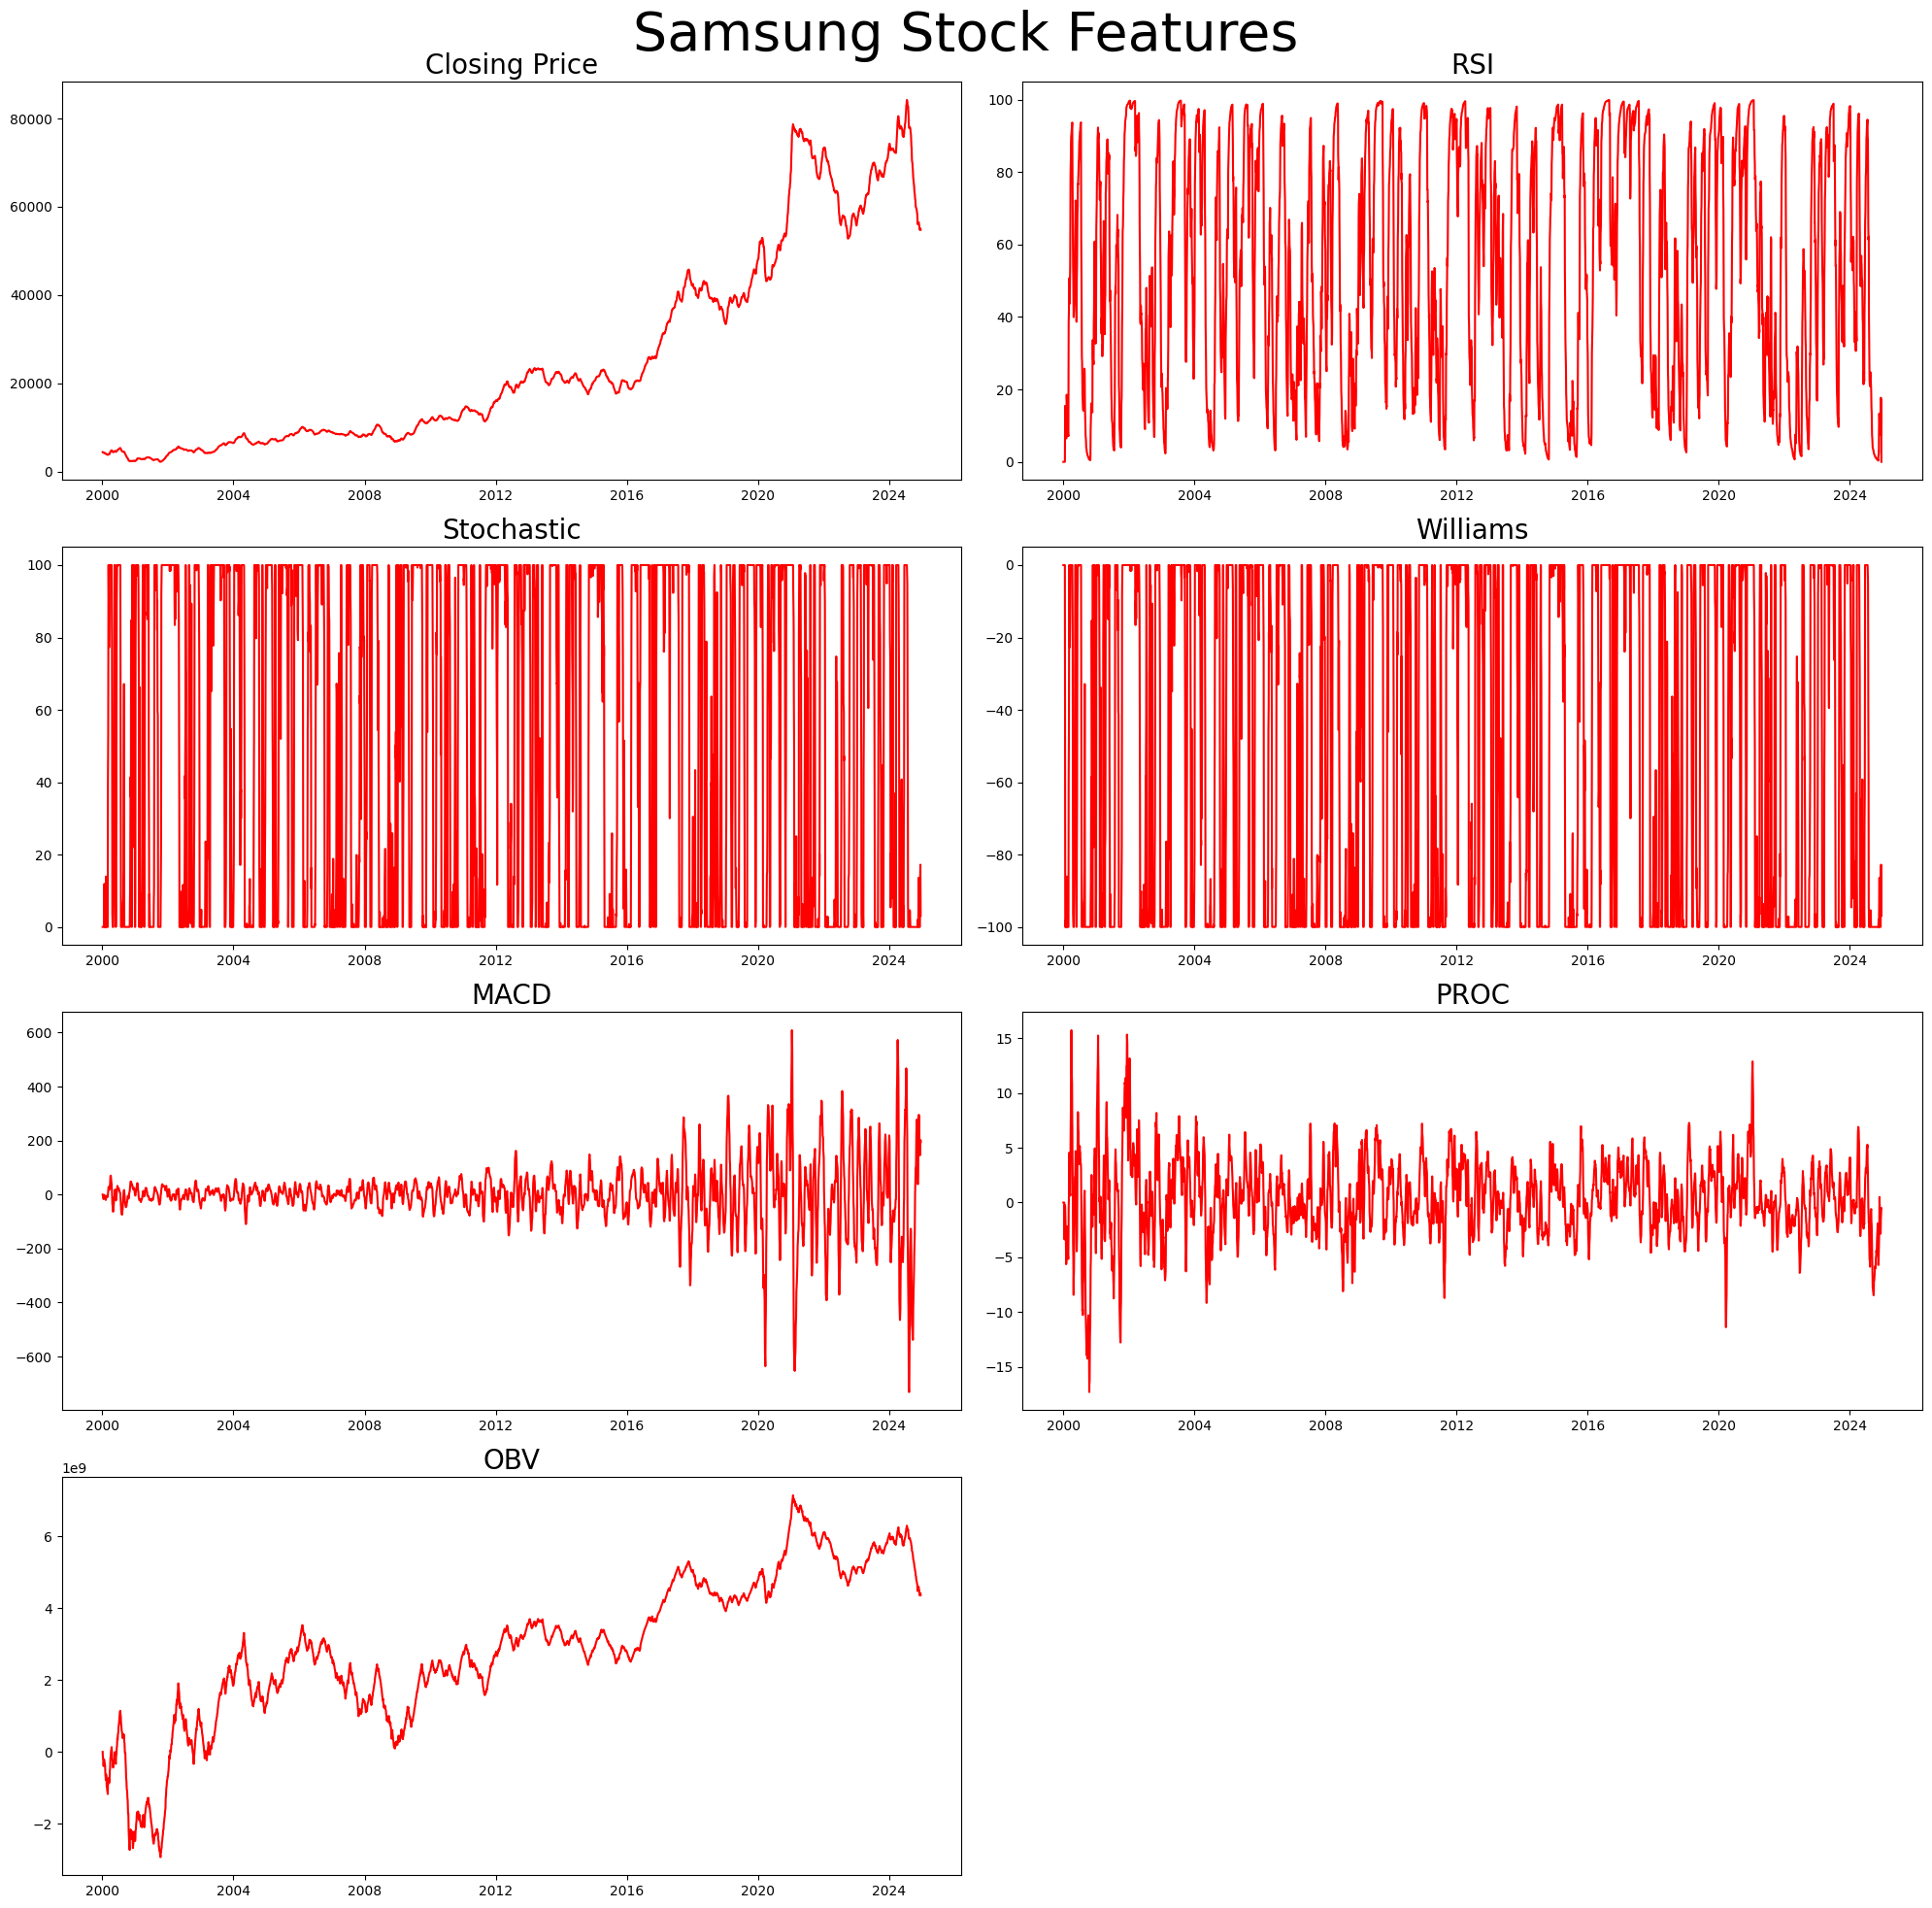

In [ ]:
#plotting samsung features
fig, axs = plt.subplots(4,2, figsize=(20,20))
fig.suptitle('Samsung Stock Features',fontsize = 40)
axs[0,0].plot(Samsung['Date'].tail(7000), Samsung['Close1'].tail(7000),color='Red')
axs[0,0].set_title('Closing Price',fontsize=20)
axs[0,1].plot(Samsung['Date'].tail(7000),Samsung['RSI'].tail(7000),color='Red')
axs[0,1].set_title('RSI',fontsize=20)
axs[1,0].plot(Samsung['Date'].tail(7000),Samsung['Stochastic'].tail(7000),color='Red')
axs[1,0].set_title('Stochastic',fontsize=20)
axs[1,1].plot(Samsung['Date'].tail(7000),Samsung['Williams'].tail(7000),color='Red')
axs[1,1].set_title('Williams',fontsize=20)
axs[2,0].plot(Samsung['Date'].tail(7000),Samsung['MACD'].tail(7000),color='Red')
axs[2,0].set_title('MACD',fontsize=20)
axs[2,1].plot(Samsung['Date'].tail(7000),Samsung['PROC'].tail(7000),color='Red')
axs[2,1].set_title('PROC',fontsize=20)
axs[3,0].plot(Samsung['Date'].tail(7000),Samsung['OBV'].tail(7000),color='Red')
axs[3,0].set_title('OBV',fontsize=20)
axs[3,1].set_visible(False)
fig.tight_layout()
plt.show()

In [ ]:
# creating a dataframe for ge data with the columns being the features of the stock
# get ge data
ge = yf.Ticker('GE')
gestock = ge.history(period="max")['Close']
geclose = ge.history(period="max")['Close'].to_numpy()

geclosesmooth = transform(geclose, 0.1)
GE = pd.Series.to_frame(gestock)
GE['Date'] = list(gestock.index)
GE['Volume'] = ge.history(period="max")['Volume']
GE = GE[['Date','Close','Volume']]
GE.reset_index(drop=True, inplace=True)

#smooth closing with alpha = 0.1

geclosesmooth = transform(GE.loc[:,'Close'], 0.1)
GE['Close1'] = geclosesmooth

# ge rsi
gersi = RSI(GE.loc[:,'Close1'])
GE['RSI'] = gersi

#ge stochastic oscillator
gestk = stochastic_oscillator(GE.loc[:,'Close1'])
GE['Stochastic'] = gestk

#ge williams
gewill = williams_R(GE.loc[:,'Close1'])
GE['Williams'] = gewill

gemacd = MACD(GE.loc[:,'Close1'])
GE['MACD'] = gemacd

geproc = PROC(GE.loc[:,'Close1'])
GE['PROC'] = geproc

geobv = OBV(GE.loc[:,'Close1'], GE.loc[:,'Volume'])
GE['OBV'] = geobv

ge30 = windowprior(GE.loc[:,'Close1'], 30)
GE['30'] = ge30

ge60 = windowprior(GE.loc[:,'Close1'],60)
GE['60'] = ge60

ge90 = windowprior(GE.loc[:,'Close1'],90)
GE['90'] = ge90



<ipython-input-18-f43fa962dc11>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  GE['Close1'] = geclosesmooth
<ipython-input-18-f43fa962dc11>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  GE['RSI'] = gersi


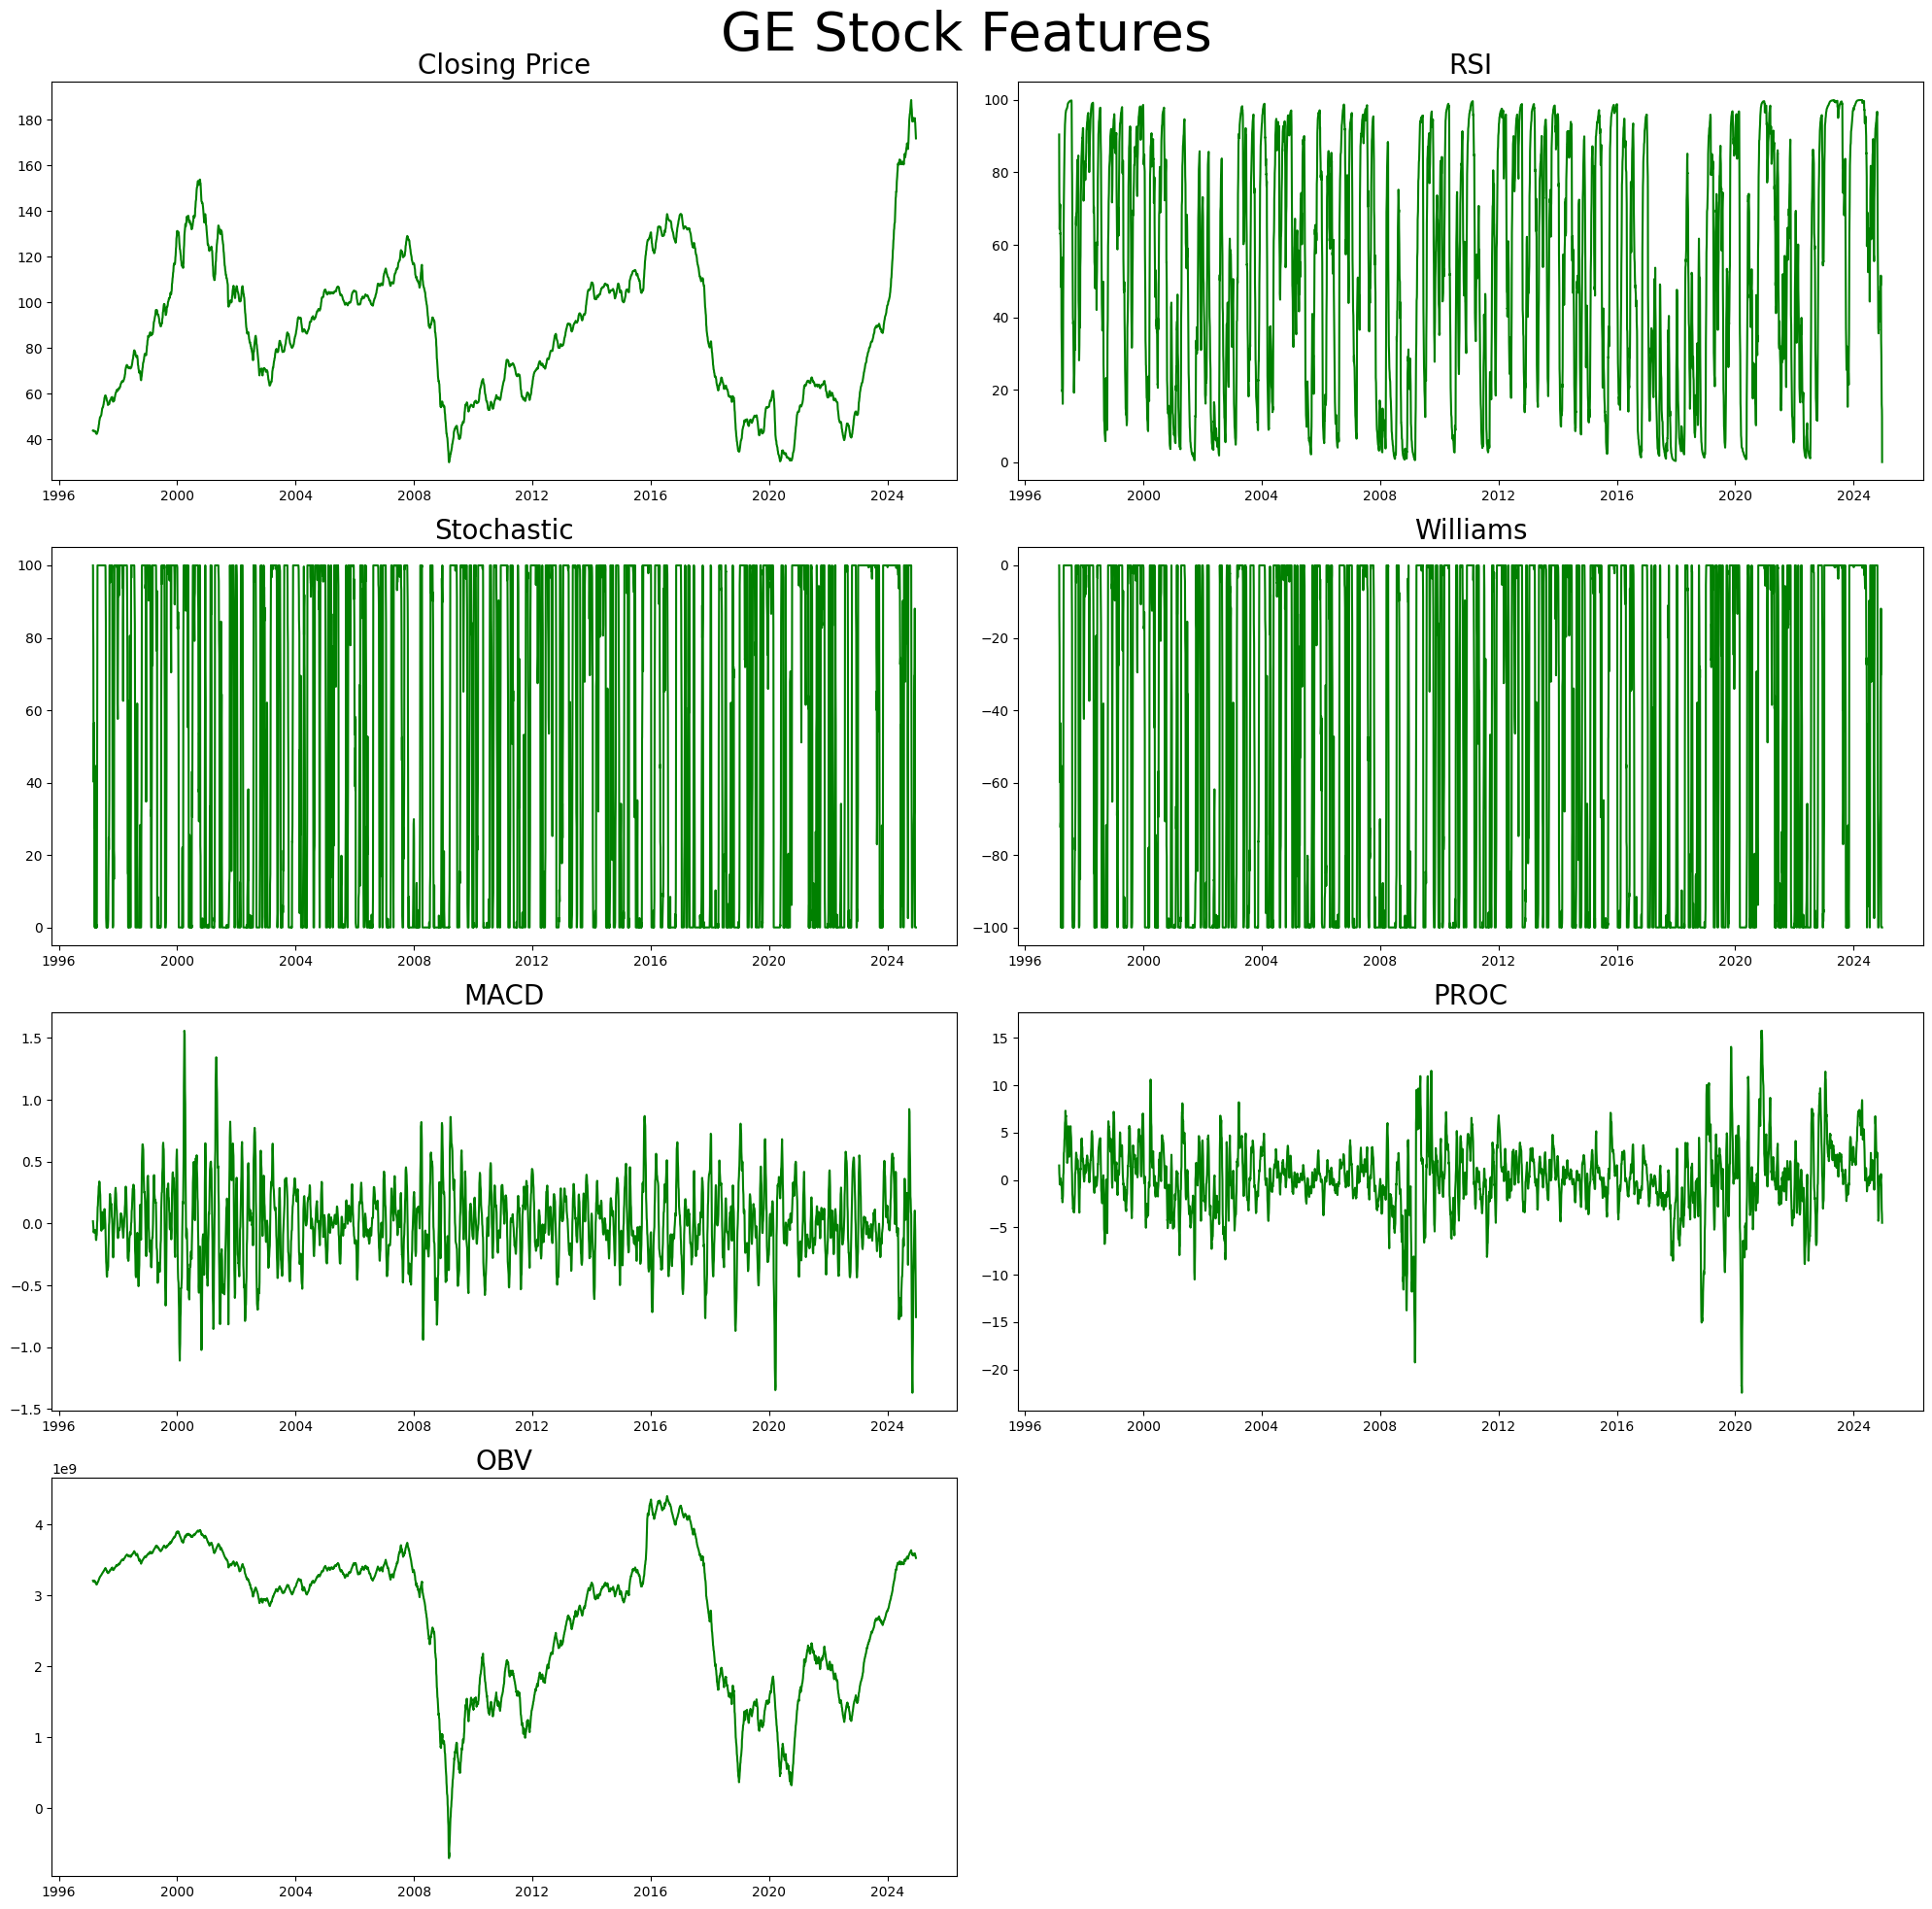

In [ ]:
#plotting ge features
fig, axs = plt.subplots(4,2, figsize=(20,20))
fig.suptitle('GE Stock Features',fontsize = 40)
axs[0,0].plot(GE['Date'].tail(7000), GE['Close1'].tail(7000),color='green')
axs[0,0].set_title('Closing Price',fontsize=20)
axs[0,1].plot(GE['Date'].tail(7000),GE['RSI'].tail(7000),color='green')
axs[0,1].set_title('RSI',fontsize=20)
axs[1,0].plot(GE['Date'].tail(7000),GE['Stochastic'].tail(7000),color='green')
axs[1,0].set_title('Stochastic',fontsize=20)
axs[1,1].plot(GE['Date'].tail(7000),GE['Williams'].tail(7000),color='green')
axs[1,1].set_title('Williams',fontsize=20)
axs[2,0].plot(GE['Date'].tail(7000),GE['MACD'].tail(7000),color='green')
axs[2,0].set_title('MACD',fontsize=20)
axs[2,1].plot(GE['Date'].tail(7000),GE['PROC'].tail(7000),color='green')
axs[2,1].set_title('PROC',fontsize=20)
axs[3,0].plot(GE['Date'].tail(7000),GE['OBV'].tail(7000),color='green')
axs[3,0].set_title('OBV',fontsize=20)
axs[3,1].set_visible(False)
fig.tight_layout()
plt.show()

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:612: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:612: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:612: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:612: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:612: UserWarning: Some inputs do not have OOB scores. This probably means too fe

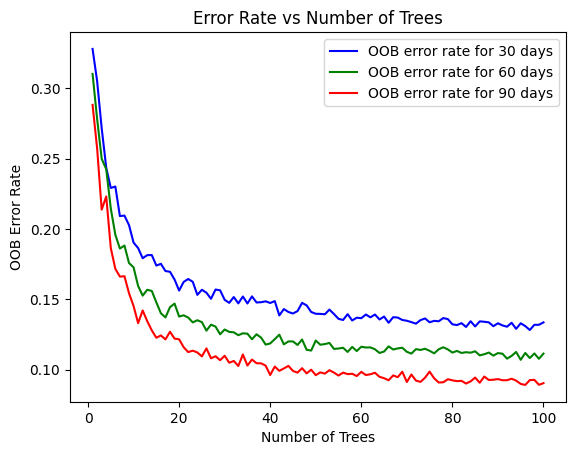

In [ ]:
#plot oob error rate for apple stock for 30,60,90 windows with random forest classifier
#THERE WILL BE A BUNCH OF WARNINGS. THIS IS BECAUSE OOB SCORE CAN'T BE CALCULATED FOR SMALL N. DON'T WORRY ABOUT THE WARNINGS. THIS SECTION OF CODE TAKES ABOUT 10 MINUTES TO RUN.
independent = ['RSI', 'Stochastic', 'Williams', 'MACD', 'PROC', 'OBV']
dependent = ['30']
error_rate_30 = []
estimators = []
X = Apple[independent]
y = Apple[dependent]
for i in range(1,101,1):
  est = i
  model = RandomForestClassifier(n_estimators= est, oob_score=True, criterion = 'gini')
  model.fit(X, y.values.ravel())
  error_rate_30.append(1-model.oob_score_)
  estimators.append(est)

y=Apple['60']
error_rate_60 = []
for i in range(1,101,1):
  est = i
  model = RandomForestClassifier(n_estimators= est, oob_score=True, criterion = 'gini')
  model.fit(X, y.values.ravel())
  error_rate_60.append(1-model.oob_score_)


y=Apple['90']
error_rate_90 = []
for i in range(1,101,1):
  est = i
  model = RandomForestClassifier(n_estimators= est, oob_score=True, criterion = 'gini')
  model.fit(X, y.values.ravel())
  error_rate_90.append(1-model.oob_score_)


plt.figure()
plt.plot(estimators, error_rate_30, label='OOB error rate for 30 days', color = 'blue')
plt.plot(estimators, error_rate_60, label='OOB error rate for 60 days', color = 'green')
plt.plot(estimators, error_rate_90, label='OOB error rate for 90 days', color = 'red')
plt.xlabel('Number of Trees')
plt.ylabel('OOB Error Rate')
plt.title('Error Rate vs Number of Trees')
plt.legend()
plt.show()

In [ ]:
OOBerror = pd.DataFrame(estimators)
OOBerror['30'] = error_rate_30
OOBerror['60'] = error_rate_60
OOBerror['90'] = error_rate_90
OOBtable = pd.DataFrame({'Training Period(Days)':[],'No. of Trees':[], 'OOB error':[]})
days = ['30','60','90']
trees = [5,25,45,65]
for day in days:
  for tree in trees:
    newrow = {'Training Period(Days)':day, 'No. of Trees':tree}
    error = OOBerror.loc[tree-1,day]
    newrow['OOB error'] = error
    row = pd.Series(newrow)
    OOBtable = pd.concat([OOBtable, row.to_frame().T], ignore_index=True)

print(OOBtable.to_string(index=False))

Training Period(Days) No. of Trees OOB error
                   30            5  0.229161
                   30           25  0.156799
                   30           45  0.139948
                   30           65  0.137785
                   60            5  0.214562
                   60           25   0.13382
                   60           45  0.120123
                   60           65  0.112913
                   90            5  0.186447
                   90           25  0.109489
                   90           45  0.099126
                   90           65  0.093989


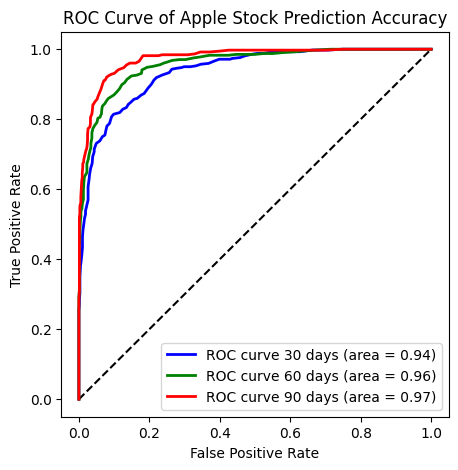

In [ ]:
X = Apple[independent]
y=Apple['30']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=100)
model = RandomForestClassifier(n_estimators= 100, oob_score=True, criterion = 'gini')
model.fit(X_train, y_train)
y_pred_prob = model.predict_proba(X_test)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(5, 5))
plt.plot(fpr, tpr, color='blue', lw=2, label='ROC curve 30 days (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

y=Apple['60']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=100)
model = RandomForestClassifier(n_estimators= 100, oob_score=True, criterion = 'gini')
model.fit(X_train, y_train)
y_pred_prob = model.predict_proba(X_test)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, color='green', lw=2, label='ROC curve 60 days (area = %0.2f)' % roc_auc)

y=Apple['90']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=100)
model = RandomForestClassifier(n_estimators= 100, oob_score=True, criterion = 'gini')
model.fit(X_train, y_train)
y_pred_prob = model.predict_proba(X_test)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, color='red', lw=2, label='ROC curve 90 days (area = %0.2f)' % roc_auc)

plt.title('ROC Curve of Apple Stock Prediction Accuracy')
plt.legend()
plt.show()

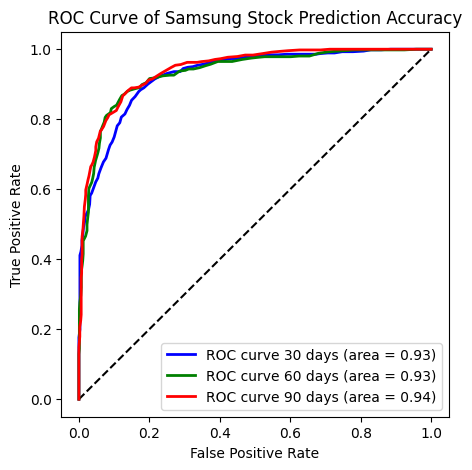

In [ ]:
X = Samsung[independent]
y=Samsung['30']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=100)
model = RandomForestClassifier(n_estimators= 100, oob_score=True, criterion = 'gini')
model.fit(X_train, y_train)
y_pred_prob = model.predict_proba(X_test)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(5, 5))
plt.plot(fpr, tpr, color='blue', lw=2, label='ROC curve 30 days (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

y=Samsung['60']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=100)
model = RandomForestClassifier(n_estimators= 100, oob_score=True, criterion = 'gini')
model.fit(X_train, y_train)
y_pred_prob = model.predict_proba(X_test)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, color='green', lw=2, label='ROC curve 60 days (area = %0.2f)' % roc_auc)

y=Samsung['90']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=100)
model = RandomForestClassifier(n_estimators= 100, oob_score=True, criterion = 'gini')
model.fit(X_train, y_train)
y_pred_prob = model.predict_proba(X_test)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, color='red', lw=2, label='ROC curve 90 days (area = %0.2f)' % roc_auc)

plt.title('ROC Curve of Samsung Stock Prediction Accuracy')
plt.legend()
plt.show()

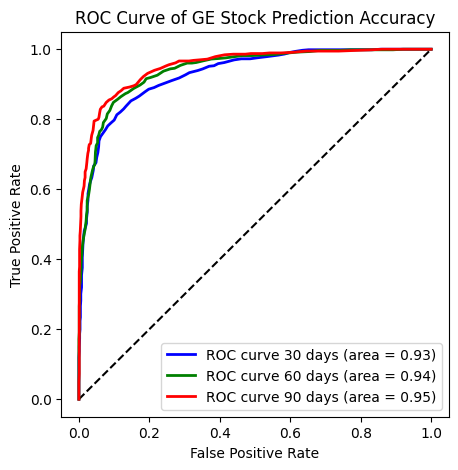

In [ ]:
X = GE[independent]
y=GE['30']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=100)
model = RandomForestClassifier(n_estimators= 100, oob_score=True, criterion = 'gini')
model.fit(X_train, y_train)
y_pred_prob = model.predict_proba(X_test)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(5, 5))
plt.plot(fpr, tpr, color='blue', lw=2, label='ROC curve 30 days (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

y=GE['60']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=100)
model = RandomForestClassifier(n_estimators= 100, oob_score=True, criterion = 'gini')
model.fit(X_train, y_train)
y_pred_prob = model.predict_proba(X_test)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, color='green', lw=2, label='ROC curve 60 days (area = %0.2f)' % roc_auc)

y=GE['90']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=100)
model = RandomForestClassifier(n_estimators= 100, oob_score=True, criterion = 'gini')
model.fit(X_train, y_train)
y_pred_prob = model.predict_proba(X_test)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, color='red', lw=2, label='ROC curve 90 days (area = %0.2f)' % roc_auc)

plt.title('ROC Curve of GE Stock Prediction Accuracy')
plt.legend()
plt.show()